# Final Report - Regression Project
Nathan Sharick - Innis Cohort

---

##### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, RFE
import os
import warnings
warnings.filterwarnings('ignore')
import math
from acquire import acquire_zillow
from prepare import prep_data
from prepare import split_data
from prepare import remove_outliers
from prepare import split_by_region

#### Acquire, Clean, Split, and Wrangle the data
- The acquire_zillow function checks for a local copy of the dataset as a .csv file and if there is not one it will pull a new copy from the CodeUp database by joining the properties_2017 and the predictions_2017 tables and pulling the columns with the selected features and rows that correspond with home sales closed in 2017 as noted in the predictions_2017 table. This query resulted in 52442 observations (rows). The acquire_zillow is located in the acompanying acquire.py file.

- Since the final acquire function was updated to only pull the selected feature columns, the overall number of rows with null values was greatly reduced and dropping all observations with incomplete data resulted in a loss of only 112 rows out of the original 52442. The prep_data function from the acompanying prepare.py file drops all rows with null values. 

- The split_data function splits the dataset by rows into three parts (train, validate, and test) so that the data exploration, model development, and model training can be done with the train set, then the models can be evaluated with a new set of observations (validate), and the final machine learning model can be tested with the third set of observaitons (test) this helps prevent overfitting the model and helps the model accurately generalize to new data moving forward. This function splits the data into 80% for the train/validate set and 20% for the test set then splits the train/validate set into 70% for train and 30% for validate and is located in the acompanying prepare.py file

- This dataset had some significant outliers in multiple columns so the dataset was further refined to remove them. The remove_outliers function calculates the interquartile range for each set of feature values and removes rows with values outside of that range (greater than the upper bound and less than the lower bound).

In [2]:
#pull the dataset from the database using the acquire_zillow function in the acquire.py file
df = acquire_zillow()
#since we are only loosing 112 rows out of 52442 if we drop all the rows with null values, that is the approach I took
df = prep_data(df)
#split the data into train, validate, and test using the split_data function from the prepare.py file
train, validate, test = split_data(df)
#assign the columns we want to remove outliers from to a variable that can be used with the function
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#use the function from the prepare.py file to remove outliers from the train dataset
train = remove_outliers(train, 1.5, out_columns)

Reading from csv file...


In [3]:
train.shape

(26695, 6)

---

### Explore Variable Interactions with visualizations and Statistical Testing

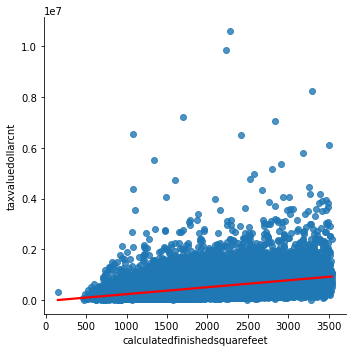

In [4]:
sns.lmplot(x='calculatedfinishedsquarefeet', y='taxvaluedollarcnt', data=train, line_kws={'color': 'red'})
plt.show()

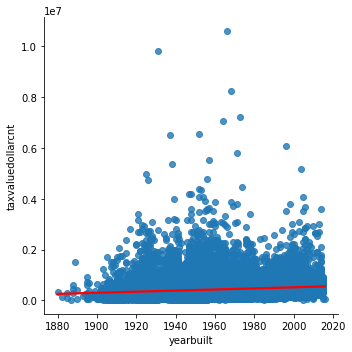

In [5]:
sns.lmplot(x='yearbuilt', y='taxvaluedollarcnt', data=train, line_kws={'color': 'red'})
plt.show()

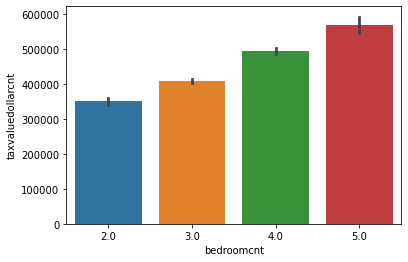

In [6]:
sns.barplot(x='bedroomcnt', y='taxvaluedollarcnt', data=train)
plt.show()

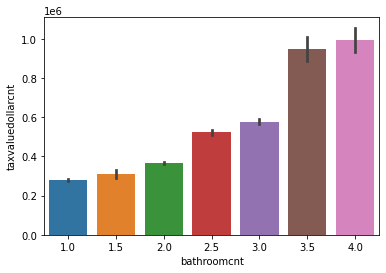

In [7]:
sns.barplot(x='bathroomcnt', y='taxvaluedollarcnt', data=train)
plt.show()

---

In [8]:
x_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_train = train[['taxvaluedollarcnt']]
x_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_validate = validate[['taxvaluedollarcnt']]

scaler = MinMaxScaler()
scaler.fit(x_train)
scaled_df = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(scaled_df, columns=x_train.columns, index=x_train.index)
val_scaled_df = scaler.transform(x_validate)
x_validate_scaled = pd.DataFrame(val_scaled_df, columns=x_validate.columns, index=x_validate.index)


In [9]:
#x_train_scaled.head()

In [10]:
#x_validate_scaled.head()

In [11]:
x = x_train_scaled
y = y_train
model = LinearRegression()
rfe = RFE(model, n_features_to_select=1).fit(x, y)
pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=x.columns)

,rfe_ranking
bedroomcnt,2
bathroomcnt,4
calculatedfinishedsquarefeet,1
yearbuilt,3


In [12]:
predictions = pd.DataFrame({'actual': validate.taxvaluedollarcnt})
predictions['baseline'] = validate.taxvaluedollarcnt.mean()

In [13]:
lm = LinearRegression()
lm.fit(x_train_scaled, y_train)
predictions['multiple_regression'] = lm.predict(x_validate_scaled)

In [14]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
poly_rm = LinearRegression()
poly_rm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
predictions['polynomial degree 2'] = poly_rm.predict(x_validate_poly)

In [15]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
predictions['polynomial only interaction'] = lm.predict(x_validate_poly)

In [16]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).apply(math.sqrt)

actual                              0.000000
baseline                       710711.727758
multiple_regression            580938.183527
polynomial degree 2            558677.387305
polynomial only interaction    550270.829353
dtype: float64

the best model improved the accuracy of the home price prediction by $160,440.90 over baseline with the validate dataset

---

#### Improving Model Accuracy by Splitting the Dataset by Region
- 

In [17]:
#pull the dataset from the database using the acquire_zillow function in the acquire.py file
df = acquire_zillow()
#since we are only loosing 112 rows out of 52442 if we drop all the rows with null values, that is the approach I took
df = prep_data(df)

df1, df2, df3 = split_by_region(df)
df1.shape, df2.shape, df3.shape

Reading from csv file...


((33880, 6), (14082, 6), (4358, 6))

In [18]:
## Dataframe 1 - Homes in Los Angeles, CA

#split the data into train, validate, and test using the split_data function from the prepare.py file
train, validate, test = split_data(df1)
#assign the columns we want to remove outliers from to a variable that can be used with the function
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#use the function from the prepare.py file to remove outliers from the train dataset
train = remove_outliers(train, 1.5, out_columns)

x_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_train = train[['taxvaluedollarcnt']]
x_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_validate = validate[['taxvaluedollarcnt']]

scaler = MinMaxScaler()
scaler.fit(x_train)
scaled_df = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(scaled_df, columns=x_train.columns, index=x_train.index)
val_scaled_df = scaler.transform(x_validate)
x_validate_scaled = pd.DataFrame(val_scaled_df, columns=x_validate.columns, index=x_validate.index)

d1_predictions = pd.DataFrame({'actual': validate.taxvaluedollarcnt})
d1_predictions['baseline'] = validate.taxvaluedollarcnt.mean()

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
d1_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)

def calculate_mse_1(y_predicted):
    return mean_squared_error(d1_predictions.actual, y_predicted)


In [19]:
## Dataframe 2 - Homes in Orange County, CA

#split the data into train, validate, and test using the split_data function from the prepare.py file
train, validate, test = split_data(df2)
#assign the columns we want to remove outliers from to a variable that can be used with the function
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#use the function from the prepare.py file to remove outliers from the train dataset
train = remove_outliers(train, 1.5, out_columns)

x_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_train = train[['taxvaluedollarcnt']]
x_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_validate = validate[['taxvaluedollarcnt']]

scaler = MinMaxScaler()
scaler.fit(x_train)
scaled_df = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(scaled_df, columns=x_train.columns, index=x_train.index)
val_scaled_df = scaler.transform(x_validate)
x_validate_scaled = pd.DataFrame(val_scaled_df, columns=x_validate.columns, index=x_validate.index)

d2_predictions = pd.DataFrame({'actual': validate.taxvaluedollarcnt})
d2_predictions['baseline'] = validate.taxvaluedollarcnt.mean()

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
d2_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)

def calculate_mse_2(y_predicted):
    return mean_squared_error(d2_predictions.actual, y_predicted)



In [20]:
## Dataframe 3 - Homes in Ventura County, CA

#split the data into train, validate, and test using the split_data function from the prepare.py file
train, validate, test = split_data(df3)
#assign the columns we want to remove outliers from to a variable that can be used with the function
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#use the function from the prepare.py file to remove outliers from the train dataset
train = remove_outliers(train, 1.5, out_columns)

x_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_train = train[['taxvaluedollarcnt']]
x_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_validate = validate[['taxvaluedollarcnt']]

scaler = MinMaxScaler()
scaler.fit(x_train)
scaled_df = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(scaled_df, columns=x_train.columns, index=x_train.index)
val_scaled_df = scaler.transform(x_validate)
x_validate_scaled = pd.DataFrame(val_scaled_df, columns=x_validate.columns, index=x_validate.index)

d3_predictions = pd.DataFrame({'actual': validate.taxvaluedollarcnt})
d3_predictions['baseline'] = validate.taxvaluedollarcnt.mean()

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
d3_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)

def calculate_mse_3(y_predicted):
    return mean_squared_error(d3_predictions.actual, y_predicted)


In [21]:
print('Best model with the Los Angeles County, CA dataset:')
print('--------------------------------------------------')
print(d1_predictions.apply(calculate_mse_1).apply(math.sqrt))
print('==================================================')
print('')
print('Best model with the Orange County, CA dataset:')
print('--------------------------------------------------')
print(d2_predictions.apply(calculate_mse_2).apply(math.sqrt))
print('==================================================')
print('')
print('Best model with the Ventura County, CA dataset:')
print('--------------------------------------------------')
print(d3_predictions.apply(calculate_mse_3).apply(math.sqrt))
print('==================================================')

Best model with the Los Angeles County, CA dataset:
--------------------------------------------------
actual                              0.000000
baseline                       937994.726017
polynomial only interaction    589841.530967
dtype: float64

Best model with the Orange County, CA dataset:
--------------------------------------------------
actual                              0.000000
baseline                       594288.684464
polynomial only interaction    407707.437513
dtype: float64

Best model with the Ventura County, CA dataset:
--------------------------------------------------
actual                              0.000000
baseline                       615413.262862
polynomial only interaction    424779.037957
dtype: float64


After splitting the dataset by region, the best model predicted home price on average by $241,789.55 better than baseline (baseline rmse - model rmse) which is an improvement of 51% from the dataset not seperated by region